In [1]:
import ee
import geemap

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project="ee-ciut")

In [ ]:
# next steps:
# - calculate change over time from 2014 to 2024 (or latest available year)
# - run more zonal stats
# - figure out an MVP format for analysis (probably static graphs)
# - rename things in spanish
# - add docs
# - deploy to streamlit or something?

In [30]:
# Filter for target partidos in Buenos Aires
target_partidos = ['La Plata', 'Berisso', 'Ensenada']
gaul_l2 = ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L2")

municipalities = (
    gaul_l2.filter(ee.Filter.eq('gaul0_name', 'Argentina'))
           .filter(ee.Filter.eq('gaul1_name', 'Buenos Aires'))
           .filter(ee.Filter.inList('gaul2_name', target_partidos))
)

# Load level 1 basins and find intersecting ones
basin_l1 = ee.FeatureCollection("projects/sat-io/open-datasets/HydroAtlas/BasinAtlas/BasinATLAS_v10_lev12")
intersecting_basins = basin_l1.filterBounds(municipalities.geometry())
aoi = intersecting_basins.geometry()

# Create map and center on AOI
Map = geemap.Map(basemap='CartoDB.Positron')
Map.centerObject(aoi, 9)

# GISA Impervious Surface
gisa = ee.ImageCollection("projects/sat-io/open-datasets/GISA_1972_2019").mosaic().clip(aoi)
Map.addLayer(gisa, {}, 'GISA 1972–2019')

# Population
population = ee.ImageCollection('WorldPop/GP/100m/pop').mosaic().clip(aoi)
Map.addLayer(population, {
    'bands': ['population'],
    'min': 0.0,
    'max': 50.0,
    'palette': ['24126c', '1fff4f', 'd4ff50']
}, 'WorldPop Population 100m')

# Nighttime lights
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
ntl_first = viirs.sort('system:time_start').first().clip(aoi)
ntl_latest = viirs.sort('system:time_start', False).first().clip(aoi)

ntl_vis = {
    'opacity': 1,
    'bands': ['avg_rad'],
    'min': 1,
    'max': 32,
    'palette': ['584d9f', '9c79c1', 'c98cbe', 'f2d192', 'e2ee82']
}
Map.addLayer(ntl_first.mask(ntl_first.neq(0)), ntl_vis, 'NTL VIIRS First')
Map.addLayer(ntl_latest.mask(ntl_latest.neq(0)), ntl_vis, 'NTL VIIRS Latest')

# Wetlands
wetlands = ee.ImageCollection("projects/sat-io/open-datasets/GWL_FCS30") \
    .sort('system:time_start', False).first().clip(aoi)
wetlands_vis = {
    'min': 180,
    'max': 187,
    'palette': [
        '#CCCCCC', '#0000FF', '#006400', '#00FF00', '#00FFFF', '#CC99FF',
        '#556B2F', '#FFFF99', '#D2B48C'
    ]
}
Map.addLayer(wetlands.mask(wetlands.neq(0)), wetlands_vis, 'GWL FCS30 Wetlands')

original_classes = [
    10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82,
    91, 92, 120, 121, 122, 130, 140, 150, 152, 153,
    181, 182, 183, 184, 185, 186, 187, 190, 200, 201,
    202, 210, 220, 0
]

recode_classes = list(range(1, len(original_classes) + 1))

# Define color palette
lc_palette = [
    "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
    "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
    "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
    "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
    "#fff5d7", "#0046c8", "#ffffff", "#ffffff", "#ffffff"
]

# Load annual dataset and mosaic
lc_annual_ic = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")
lc_mosaic = lc_annual_ic.mosaic().clip(aoi)

# Select a specific year band (e.g., band 'b23' for 2021 if b1 = 1999)
selected_band = lc_mosaic.select('b23')  # Change this for a different year

# Remap class codes to sequential integers for visualization
reclassed = selected_band.remap(original_classes, recode_classes)

# Add to map
Map.addLayer(
    reclassed,
    {'min': 1, 'max': len(recode_classes), 'palette': lc_palette},
    'GLC FCS 2021'
)

Map.addLayer(intersecting_basins.style(**{
    'color': 'black',
    'fillColor': '00000000',
    'width': 1
}), {}, 'Intersecting Basins')

Map

Map(center=[-34.963839822523525, -58.01607980918299], controls=(WidgetControl(options=['position', 'transparen…

In [38]:
# Load the Global Buildings Dataset for Argentina (using the ISO code ARG)
buildings = ee.FeatureCollection("projects/sat-io/open-datasets/VIDA_COMBINED/ARG")

# Clip the buildings to your area of interest
buildings_clipped = buildings.filterBounds(aoi)

# Add the clipped buildings to the map
Map.addLayer(
    buildings_clipped.style(**{
        'fillColor': '#FF5500',
        'color': '#FF0000',
        'width': 1
    }),
    {},
    'VIDA Buildings'
)

In [32]:
# Calculate zonal statistics for each subbasin
# 1. Total population per subbasin
pop_stats = population.reduceRegions(
    collection=intersecting_basins,
    reducer=ee.Reducer.sum(),
    scale=100  # WorldPop resolution is 100m
)

# 2. Impervious surface cover as fraction of basin area
# First calculate the area of each basin in square kilometers
basins_with_area = intersecting_basins.map(
    lambda feature: feature.set('area_km2', feature.geometry().area().divide(1e6))
)

# Calculate impervious surface area
# GISA is 0-100 percent, so we need to convert to 0-1 fraction first
gisa_fraction = gisa.divide(100)
impervious_stats = gisa_fraction.reduceRegions(
    collection=basins_with_area,
    reducer=ee.Reducer.sum(),
    scale=30  # Assuming GISA resolution is 30m
)

# Calculate the actual fraction by dividing by basin area (in pixels)
impervious_stats = impervious_stats.map(
    lambda feature: feature.set({
        'impervious_km2': feature.get('sum'),
        'impervious_fraction': ee.Number(feature.get('sum')).divide(
            feature.geometry().area().divide(900)  # 30m pixels = 900 sq m each
        )
    })
)

# 3. Total area of wetlands per basin
# First, create a binary wetland mask (1 where wetlands exist, 0 elsewhere)
wetland_mask = wetlands.gt(0)
wetland_stats = wetland_mask.reduceRegions(
    collection=basins_with_area,
    reducer=ee.Reducer.sum(),
    scale=30  # Assuming wetlands data resolution is 30m
)

# Convert pixel count to area in square kilometers
wetland_stats = wetland_stats.map(
    lambda feature: feature.set({
        'wetland_area_km2': ee.Number(feature.get('sum')).multiply(900).divide(1e6)
    })
)

# Merge all statistics into a single feature collection
merged_stats = pop_stats.map(
    lambda feature: ee.Feature(feature.geometry(), {
        'basin_id': feature.get('HYBAS_ID'),
        'basin_name': feature.get('HYBAS_NAME'),
        'population': feature.get('sum')
    })
)

merged_stats = merged_stats.map(
    lambda feature: feature.set({
        'impervious_fraction': impervious_stats.filter(
            ee.Filter.equals('HYBAS_ID', feature.get('basin_id'))
        ).first().get('impervious_fraction'),
        'impervious_km2': impervious_stats.filter(
            ee.Filter.equals('HYBAS_ID', feature.get('basin_id'))
        ).first().get('impervious_km2'),
        'wetland_area_km2': wetland_stats.filter(
            ee.Filter.equals('HYBAS_ID', feature.get('basin_id'))
        ).first().get('wetland_area_km2'),
        'area_km2': basins_with_area.filter(
            ee.Filter.equals('HYBAS_ID', feature.get('basin_id'))
        ).first().get('area_km2')
    })
)

# Print statistics to console
print('Zonal statistics for each basin:')
print(merged_stats.getInfo())

Zonal statistics for each basin:
{'type': 'FeatureCollection', 'columns': {'area_km2': 'Number', 'impervious_fraction': 'Number', 'impervious_km2': 'Float', 'wetland_area_km2': 'Number'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-58.191665626269106, -34.91666530703281], [-58.1909298885243, -34.924196704492395], [-58.18117334987954, -34.92561916024291], [-58.172995330073846, -34.93271802740534], [-58.17083272824185, -34.93333339103741], [-58.17083272824185, -34.937498237125084], [-58.17048039382788, -34.94828478648045], [-58.16492434511708, -34.95381403295162], [-58.160077344007476, -34.95451856484257], [-58.15242551133975, -34.96214809931293], [-58.12257628441827, -34.962852659422595], [-58.11492443593815, -34.9704821429335], [-58.11249870226144, -34.97083442881976], [-58.11160248303866, -34.967329577596225], [-58.10416466508159, -34.9666651841085], [-58.103598404094654, -34.96028865636861], [-58.10056620885093, -34.95637802271207], [-58.099112

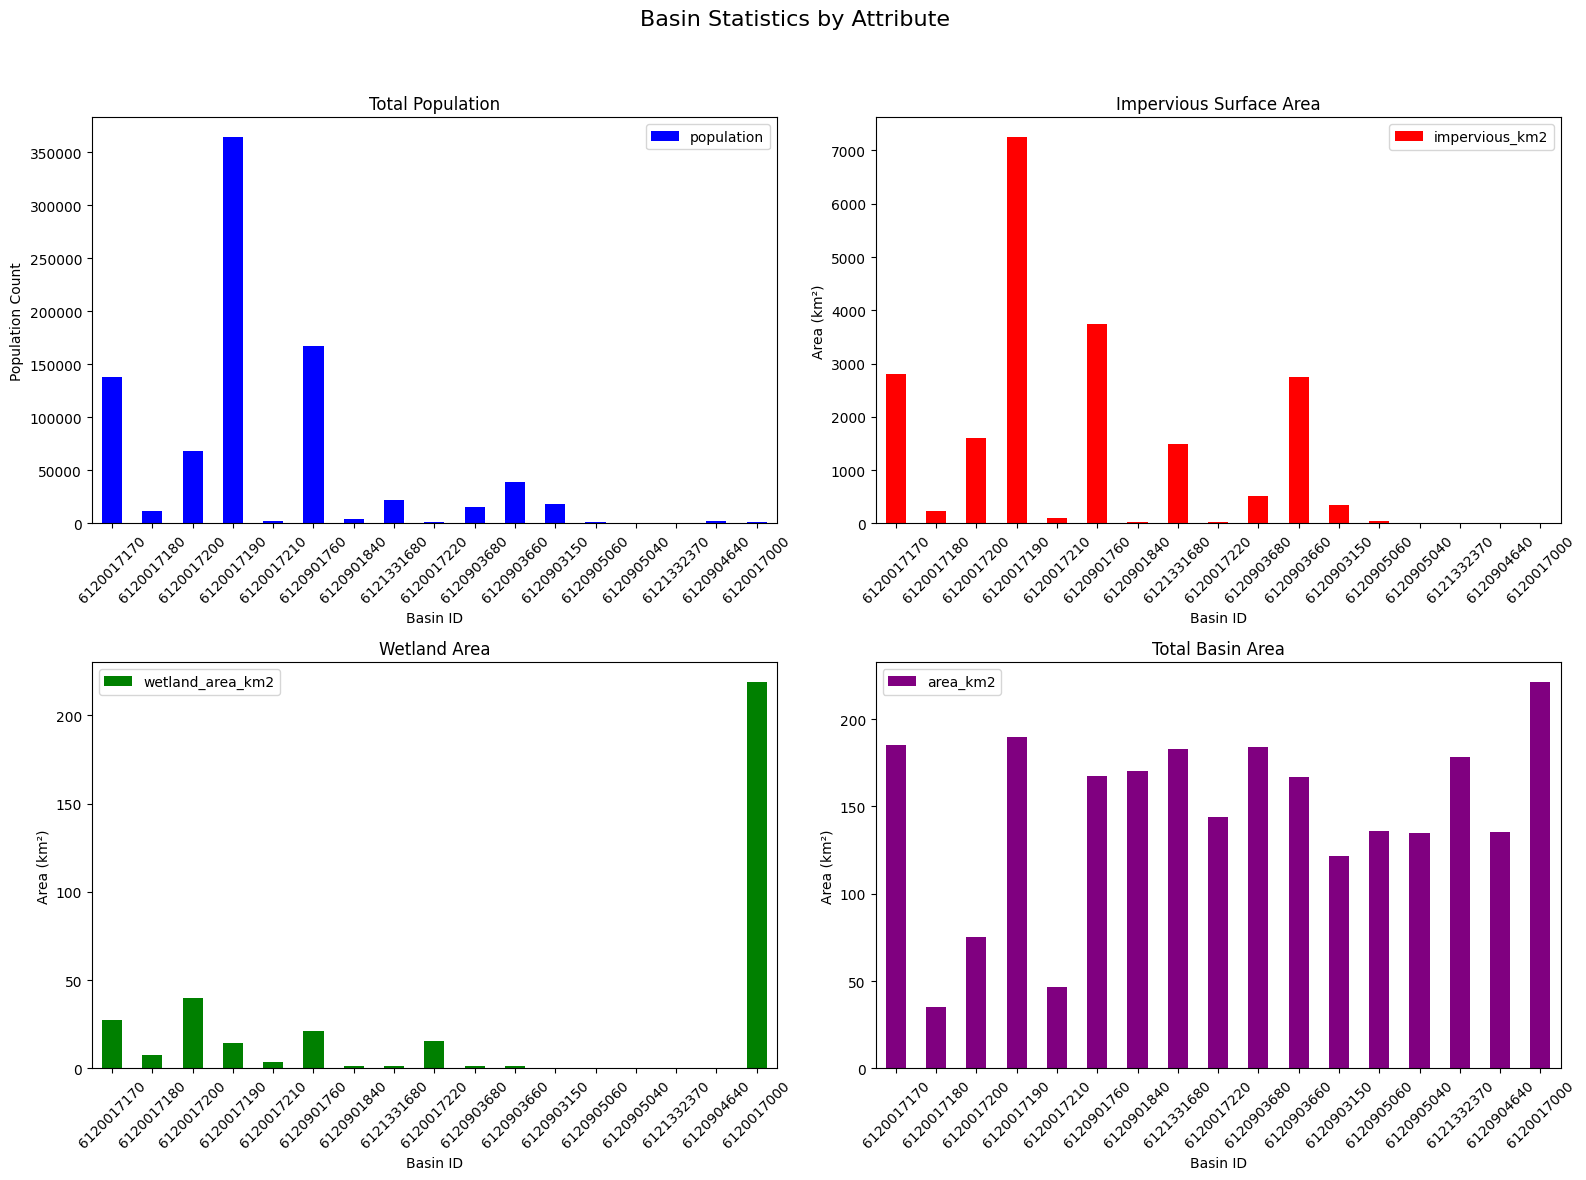

<Figure size 1000x600 with 0 Axes>

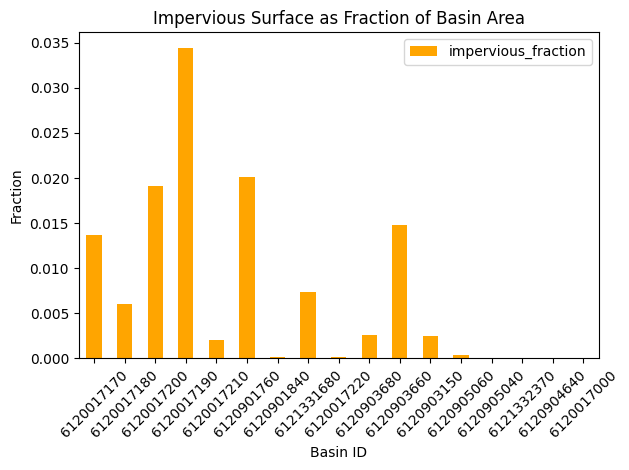

In [37]:
# Add charts to visualize basin statistics using geemap
# First, convert FeatureCollection to pandas DataFrame
basin_stats_df = geemap.ee_to_df(merged_stats)

# Create multiple charts using pandas/matplotlib
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Basin Statistics by Attribute', fontsize=16)

# Population chart
basin_stats_df.plot(
    x='basin_id', 
    y=['population'], 
    kind='bar',
    ax=axes[0, 0],
    color='blue'
)
axes[0, 0].set_title('Total Population')
axes[0, 0].set_xlabel('Basin ID')
axes[0, 0].set_ylabel('Population Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Impervious surface chart
basin_stats_df.plot(
    x='basin_id', 
    y=['impervious_km2'], 
    kind='bar',
    ax=axes[0, 1],
    color='red'
)
axes[0, 1].set_title('Impervious Surface Area')
axes[0, 1].set_xlabel('Basin ID')
axes[0, 1].set_ylabel('Area (km²)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Wetland area chart
basin_stats_df.plot(
    x='basin_id', 
    y=['wetland_area_km2'], 
    kind='bar',
    ax=axes[1, 0],
    color='green'
)
axes[1, 0].set_title('Wetland Area')
axes[1, 0].set_xlabel('Basin ID')
axes[1, 0].set_ylabel('Area (km²)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Total basin area chart
basin_stats_df.plot(
    x='basin_id', 
    y=['area_km2'], 
    kind='bar',
    ax=axes[1, 1],
    color='purple'
)
axes[1, 1].set_title('Total Basin Area')
axes[1, 1].set_xlabel('Basin ID')
axes[1, 1].set_ylabel('Area (km²)')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

# Optional: You can also create a separate chart for impervious fraction
plt.figure(figsize=(10, 6))
basin_stats_df.plot(
    x='basin_id',
    y=['impervious_fraction'],
    kind='bar',
    color='orange'
)
plt.title('Impervious Surface as Fraction of Basin Area')
plt.xlabel('Basin ID')
plt.ylabel('Fraction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# land cover change (endorsed by WRI)

//Setup basemaps
var snazzy = require("users/aazuspan/snazzy:styles");
snazzy.addStyle("https://snazzymaps.com/style/132/light-gray", "Grayscale");

var palette = [
  "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000", 
  "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00", 
  "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf", 
  "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc", 
  "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
];

// Function to recode class values into sequential values starting from 1 onwards
var recodeClasses = function(image) {
  // Define the class values
  var classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122, 
                 130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200, 
                 201, 202, 210, 220, 0];
  var reclassed = image.remap(classes, ee.List.sequence(1, classes.length));
  return reclassed;
};

// Function to add a layer with given settings
var addLayer = function(image, name) {
  Map.addLayer(image, {palette: palette}, name,false);
};

// Apply the function to your images and add layers
addLayer(recodeClasses(five_year.mosaic().select('b1')), 'GLC FCS 1985');
addLayer(recodeClasses(five_year.mosaic().select('b2')), 'GLC FCS 1990',false);
addLayer(recodeClasses(five_year.mosaic().select('b3')), 'GLC FCS 1995',false);

// Load the GLC-FCS30D collection
var image = annual.mosaic();

// Iterate over each band (year) in the image
for (var i = 1; i <= 23; i++) {
  var year = 1999 + i; // starts at year 2000 for annual maps
  var layerName = "GLC FCS " + year.toString();
  var band = image.select("b" + i);
  
  // Apply the function to the band and add layer
  addLayer(recodeClasses(band), layerName);
}

// Define a dictionary for legend and visualization
var dict = {
  "names": [
    "Rainfed cropland",
    "Herbaceous cover cropland",
    "Tree or shrub cover (Orchard) cropland",
    "Irrigated cropland",
    "Open evergreen broadleaved forest",
    "Closed evergreen broadleaved forest",
    "Open deciduous broadleaved forest (0.15<fc<0.4)",
    "Closed deciduous broadleaved forest (fc>0.4)",
    "Open evergreen needle-leaved forest (0.15< fc <0.4)",
    "Closed evergreen needle-leaved forest (fc >0.4)",
    "Open deciduous needle-leaved forest (0.15< fc <0.4)",
    "Closed deciduous needle-leaved forest (fc >0.4)",
    "Open mixed leaf forest (broadleaved and needle-leaved)",
    "Closed mixed leaf forest (broadleaved and needle-leaved)",
    "Shrubland",
    "Evergreen shrubland",
    "Deciduous shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (fc<0.15)",
    "Sparse shrubland (fc<0.15)",
    "Sparse herbaceous (fc<0.15)",
    "Swamp",
    "Marsh",
    "Flooded flat",
    "Saline",
    "Mangrove",
    "Salt marsh",
    "Tidal flat",
    "Impervious surfaces",
    "Bare areas",
    "Consolidated bare areas",
    "Unconsolidated bare areas",
    "Water body",
    "Permanent ice and snow",
    "Filled value"
  ],
  "colors": [
    "#ffff64",
    "#ffff64",
    "#ffff00",
    "#aaf0f0",
    "#4c7300",
    "#006400",
    "#a8c800",
    "#00a000",
    "#005000",
    "#003c00",
    "#286400",
    "#285000",
    "#a0b432",
    "#788200",
    "#966400",
    "#964b00",
    "#966400",
    "#ffb432",
    "#ffdcd2",
    "#ffebaf",
    "#ffd278",
    "#ffebaf",
    "#00a884",
    "#73ffdf",
    "#9ebb3b",
    "#828282",
    "#f57ab6",
    "#66cdab",
    "#444f89",
    "#c31400",
    "#fff5d7",
    "#dcdcdc",
    "#fff5d7",
    "#0046c8",
    "#ffffff",
    "#ffffff",
    "#ffffff"
  ]
};

var legend = ui.Panel({
  style: {
    position: 'middle-right',
    padding: '8px 15px'
  }
});

// Create and add the legend title.
var legendTitle = ui.Label({
  value: 'GLC FCS Classes',
  style: {
    fontWeight: 'bold',
    fontSize: '18px',
    margin: '0 0 4px 0',
    padding: '0'
  }
});
legend.add(legendTitle);

var loading = ui.Label('Loading legend...', {margin: '2px 0 4px 0'});
legend.add(loading);

  // Creates and styles 1 row of the legend.
  var makeRow = function(color, name) {
    // Create the label that is actually the colored box.
    var colorBox = ui.Label({
      style: {
        backgroundColor: color,
        // Use padding to give the box height and width.
        padding: '8px',
        margin: '0 0 4px 0'
      }
    });

  // Create the label filled with the description text.
  var description = ui.Label({
    value: name,
    style: {margin: '0 0 4px 6px'}
  });

  return ui.Panel({
    widgets: [colorBox, description],
    layout: ui.Panel.Layout.Flow('horizontal')
  });
};
  var palette = dict['colors'];
  var names = dict['names'];
  loading.style().set('shown', false);

  for (var i = 0; i < names.length; i++) {
    legend.add(makeRow(palette[i], names[i]));
  }

// Print the panel containing the legend
print(legend);

In [ ]:
# ghsl and worldpop
https://gee-community-catalog.org/projects/ghsl/


var dataset = ee.ImageCollection('WorldPop/GP/100m/pop');

var visualization = {
  bands: ['population'],
  min: 0.0,
  max: 50.0,
  palette: ['24126c', '1fff4f', 'd4ff50']
};

Map.setCenter(113.643, 34.769, 7);

Map.addLayer(dataset, visualization, 'Population');

In [ ]:
# nighttime lights (seems to be at 100-250m resolution)
var image = npp_viirs_ntl.sort('system:time_start').first()
var vis = {"opacity":1,"bands":["b1"],min: 1, max: 32,"palette":["584d9f","9c79c1","c98cbe","f2d192","e2ee82"]}
var formattedDate = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd');
Map.addLayer(image.mask(image.neq(0)),vis,'NTL VIIRS '+formattedDate.getInfo())

var image = npp_viirs_ntl.sort('system:time_start',false).first()
var formattedDate = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd');
Map.addLayer(image.mask(image.neq(0)),vis,'NTL VIIRS '+formattedDate.getInfo())